In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost jupyter

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/124.9 MB 6.3 MB/s eta 0:00:20
    --------------------------------------- 2.9/124.9 MB 7.6 MB/s eta 0:00:16
   - -------------------------------------- 5.5/124.9 MB 9.3 MB/s eta 0:00:13
   -- ------------------------------------- 8.9/124.9 MB 11.1 MB/s eta 0:00:11
   ---- ----------------------------------- 13.9/124.9 MB 13.6 MB/s eta 0:00:09
   ------ --------------------------------- 19.9/124.9 MB 16.3 MB/s eta 0:00:07
   -------- ------------------------------- 26.7/124.9 MB 18.8 MB/s eta 0:00:06
   ----------- ---------------------------- 37.2/124.9 MB 23.0 MB/s eta 0:00:04
   --------------- ------------------------ 49.5/124.9 MB 27.0 MB/s eta 0:00:03
   -------------------- ------------------- 63.7/124.9 MB 31.0 MB/s eta 0:00:02
   ------------------------- -------------- 79.4/124.9 MB 35.0 MB/s eta 0:00:02
   ------------------------------ --------- 95.7/124.9 M

In [31]:
import pandas as pd
df = pd.read_csv("fraud_oracle.csv")
print(df)

      Month  WeekOfMonth  DayOfWeek     Make AccidentArea DayOfWeekClaimed  \
0       Dec            5  Wednesday    Honda        Urban          Tuesday   
1       Jan            3  Wednesday    Honda        Urban           Monday   
2       Oct            5     Friday    Honda        Urban         Thursday   
3       Jun            2   Saturday   Toyota        Rural           Friday   
4       Jan            5     Monday    Honda        Urban          Tuesday   
...     ...          ...        ...      ...          ...              ...   
15415   Nov            4     Friday   Toyota        Urban          Tuesday   
15416   Nov            5   Thursday  Pontiac        Urban           Friday   
15417   Nov            5   Thursday   Toyota        Rural           Friday   
15418   Dec            1     Monday   Toyota        Urban         Thursday   
15419   Dec            2  Wednesday   Toyota        Urban         Thursday   

      MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  .

In [6]:
print(df['FraudFound_P'].value_counts())

FraudFound_P
0    14497
1      923
Name: count, dtype: int64


In [12]:
threshold = 0.3 * len(df)
df_clean = df.dropna(thresh=threshold, axis=1)

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy = 'median')
df_clean[['Age', 'Deductible']] = num_imputer.fit_transform(df_clean[['Age', 'Deductible']])
cat_imputer = SimpleImputer(strategy = 'most_frequent')
df_clean[['PolicyType', 'BasePolicy']] = cat_imputer.fit_transform(df_clean[['PolicyType', 'BasePolicy']])

In [22]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder_features = encoder.fit_transform(df_clean[['PolicyType', 'BasePolicy']])
encoder_df = pd.DataFrame(encoder_features, columns = encoder.get_feature_names_out())

df_processed = pd.concat([df_clean.drop(['PolicyType', 'BasePolicy'], axis=1), encoded_df], axis=1)

In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [38]:
print(df['Days_Policy_Accident'].unique())
print(df['Days_Policy_Claim'].unique())

['more than 30' '15 to 30' 'none' '1 to 7' '8 to 15']
['more than 30' '15 to 30' '8 to 15' 'none']


In [84]:
time_mapping = {
    'more than 30' : 0,
    '15 to 30' : 1,
    '8 to 15' : 1,
    '1 to 7' : 1,
    'none' : 0
}

df['high_risk_accident'] = df['Days_Policy_Accident'].map(time_mapping).fillna(0)
df['high_risk_claim'] = df['Days_Policy_Claim'].map(time_mapping).fillna(0)
df['high_risk'] = (df['high_risk_accident'] | df['high_risk_claim']).astype(int)
sample = df[['Days_Policy_Accident', 'Days_Policy_Claim', 'high_risk']]
fraud_rate = df.groupby('high_risk')['FraudFound_P'].mean()
print(fraud_rate)

high_risk
0    0.059551
1    0.093525
Name: FraudFound_P, dtype: float64


C:\Users\rishi\AppData\Local\Temp\ipykernel_7528\1341327906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = fraud_rate, palette='viridis')


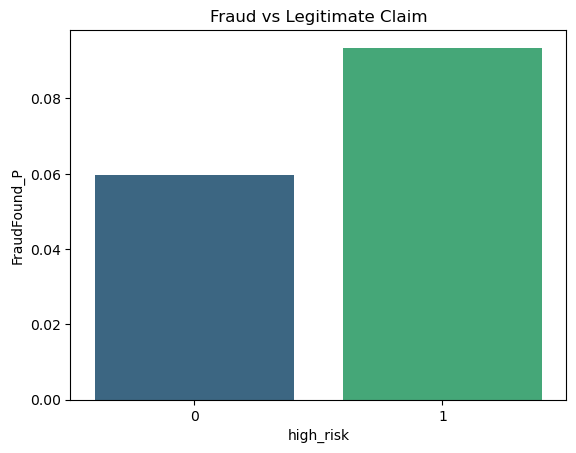

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data = fraud_rate, palette='viridis')
plt.title("Fraud vs Legitimate Claim")
plt.show()